In [8]:
# Here we go...  Opening and importing dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from   sqlalchemy.ext.automap import automap_base
from   sqlalchemy.orm import Session
from   sqlalchemy import create_engine, func

In [10]:
# create engine to hawaii.sqlite
database_path = "../Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_measurement_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Get value of first column
latest_date = last_measurement_data_point [0]
#Format date as YYYY-MM-DD
latest_date = dt.datetime.strptime(latest_date,'%Y-%m-%d')
latest_date = latest_date.date()
print(latest_date)

2017-08-23


In [16]:
# Calculate the date one year from the last date in data set.
date_year_ago = latest_date - relativedelta(years=1)
print(date_year_ago)

2016-08-23


In [17]:
# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_year_ago).all()

In [18]:
# Save the query results as a Pandas DataFrame 
precip_df = pd.DataFrame(last_year_data, columns = ['date', 'prcp'])
# If any NA values are present, drop that row or column.
precip_df = precip_df.dropna(how="any")

# Set the index to the date column
precip_df = precip_df.set_index("date")

# Sort the dataframe by date
precip_df = precip_df.sort_values(by=['date'])
precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


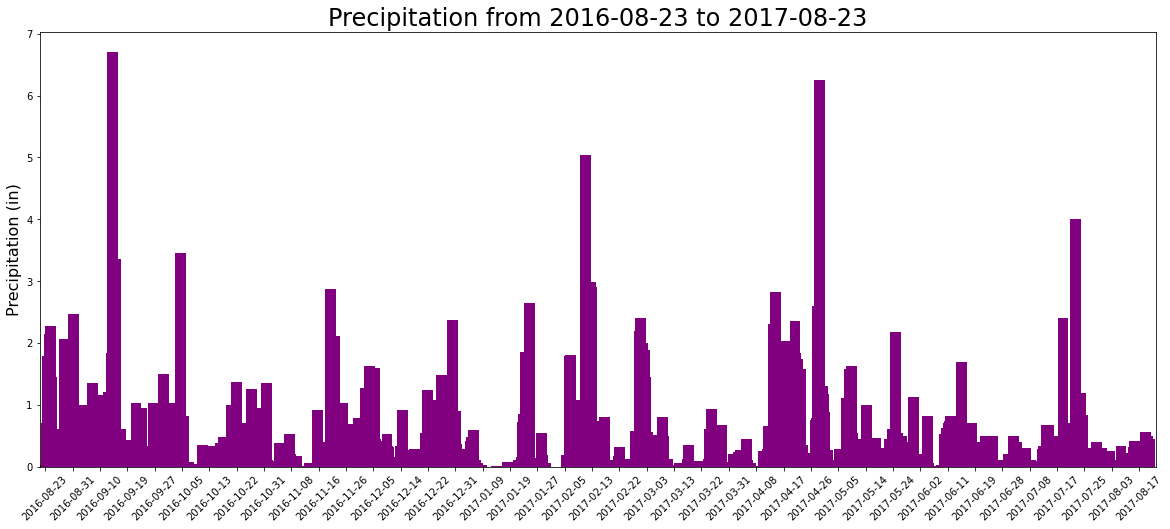

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data - Precipitation from Aug 23, 2016 to Aug 23, 2017.
ax1 = precip_df.plot.bar(figsize=(20,8), width=20, color='purple') #I love purple!
# Remove legend and xlabel to allow space for xticks
ax1.get_legend().remove()
ax1.set_xlabel("")
# Indicate ylabel
ax1.set_ylabel("Precipitation (in)", fontsize=16)
# Set plot title in place of legend
ax1.set_title(f"Precipitation from {date_year_ago} to {latest_date}", fontsize=24)
# Set frequency of xticks every 50 values
ax1.set_xticks(ax1.get_xticks()[::50])
# Make xticks legible by rotating the text
plt.xticks(rotation = 45, fontsize=10)
# Save plot to a png file
plt.savefig("../Images/precipitation.png")
# Display the plot
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# Generate descriptive statistics
stats = precip_df["prcp"].describe()
# Storing precipitation stats into a dataframe
stats_df = pd.DataFrame(stats)
# Renaming original prcp column as Precipitation
stats_df.rename(columns = {"prcp": "Precipitation"})

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number stations in the dataset
print(f"Stations available in this dataset:", session.query(Station).group_by(Station.station).count())

Stations available in this dataset: 9


In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# Using the query to display top values
session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query
# Storing query result to identify the top value
most_active_station=session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).\
    desc()).first()

# Storing first column value as the most active station
most_active_station_id = most_active_station[0]

print(f"The most active station is: ",most_active_station_id)

The most active station is:  USC00519281


In [23]:
# Calculate the lowest, highest, and average temperature for the most active station id
# Query to calculate min, max, and avg values
most_active = session.query(func.min(Measurement.tobs),\
                            func.max(Measurement.tobs),\
                            func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()

# Printing the values found
for lowest_temp, highest_temp, avg_temp in most_active:
    print(f"The lowest temperature recorded at {most_active_station_id} was {lowest_temp}.")
    print(f"The highest temperature recorded at {most_active_station_id} was {highest_temp}.")
    avg_temp = round(avg_temp,1)
    print(f"The average temperature recorded at {most_active_station_id} was {avg_temp}.")

# Creating df to display values found
temperature_df = pd.DataFrame({
    "Lowest Temperature": lowest_temp,
    "Highest Temperature": highest_temp,
    "Average Temperature": avg_temp
}, index=[0])

# Display df
temperature_df

The lowest temperature recorded at USC00519281 was 54.0.
The highest temperature recorded at USC00519281 was 85.0.
The average temperature recorded at USC00519281 was 71.7.


,Lowest Temperature,Highest Temperature,Average Temperature
0,54.0,85.0,71.7


In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
filter(Measurement.station == most_active_station_id).first()

# Store first column value to identify the latest observation date
latest_date = most_active[0]
# Format the date as YYY-MM-DD
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
# Calculate the date for exactly one year from the latest observation date
date_year_ago = latest_date - relativedelta(years=1)

# Filter the data from the last year date
last_year_data = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station == most_active_station_id).\
filter(Measurement.date >= date_year_ago).all()

# Create a df with only the date and total observations per date
last_year_data_df = pd.DataFrame(last_year_data, columns=['date', 'total_obs'])

# Display df
last_year_data_df

,date,total_obs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0
...,...,...
352,2017-08-14,77.0
353,2017-08-15,77.0
354,2017-08-16,76.0
355,2017-08-17,76.0


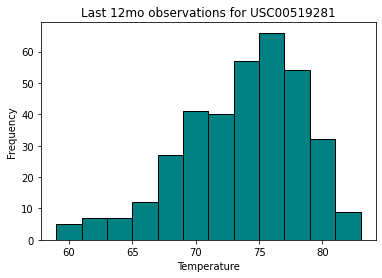

In [25]:
# And this is the  plot
df = pd.DataFrame(last_year_data_df, columns=['total_obs'])

# Formating plot
df.plot.hist(bins=12, edgecolor = "black", color = "teal")

# Adding title, xlabel and removing legend
plt.title(f"Last 12mo observations for {most_active_station_id}")
plt.xlabel('Temperature')
plt.gca().get_legend().remove()

# Storing plot into a png file
plt.savefig("../Images/last12months.png")

# Showing plot
plt.show()


# Close session

In [26]:
# Close Session
session.close()